In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
# fetch dataset 
energy_efficiency = fetch_ucirepo(id=242) 
  
# data (as pandas dataframes) 
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets 

In [2]:
# Changing column names
X.columns = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Orientation', 'Glazing Area', 'Glazing Area Distribution']
y.columns = ['Heating Load', 'Cooling Load']
print(X)

     Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                    0.98         514.5      294.0     110.25             7.0   
1                    0.98         514.5      294.0     110.25             7.0   
2                    0.98         514.5      294.0     110.25             7.0   
3                    0.98         514.5      294.0     110.25             7.0   
4                    0.90         563.5      318.5     122.50             7.0   
..                    ...           ...        ...        ...             ...   
763                  0.64         784.0      343.0     220.50             3.5   
764                  0.62         808.5      367.5     220.50             3.5   
765                  0.62         808.5      367.5     220.50             3.5   
766                  0.62         808.5      367.5     220.50             3.5   
767                  0.62         808.5      367.5     220.50             3.5   

     Orientation  Glazing A

In [3]:
orientation_encoding = pd.get_dummies(X['Orientation'], prefix='Orientation', prefix_sep='=')
glazing_area_encoding = pd.get_dummies(X['Glazing Area Distribution'], prefix='Glazing_Area_Distribution', prefix_sep='=')
X = pd.concat([X.drop('Orientation', axis=1), orientation_encoding], axis=1)
X = pd.concat([X.drop('Glazing Area Distribution', axis=1), glazing_area_encoding], axis=1)
y1 = y['Heating Load'].values
y2 = y['Cooling Load'].values

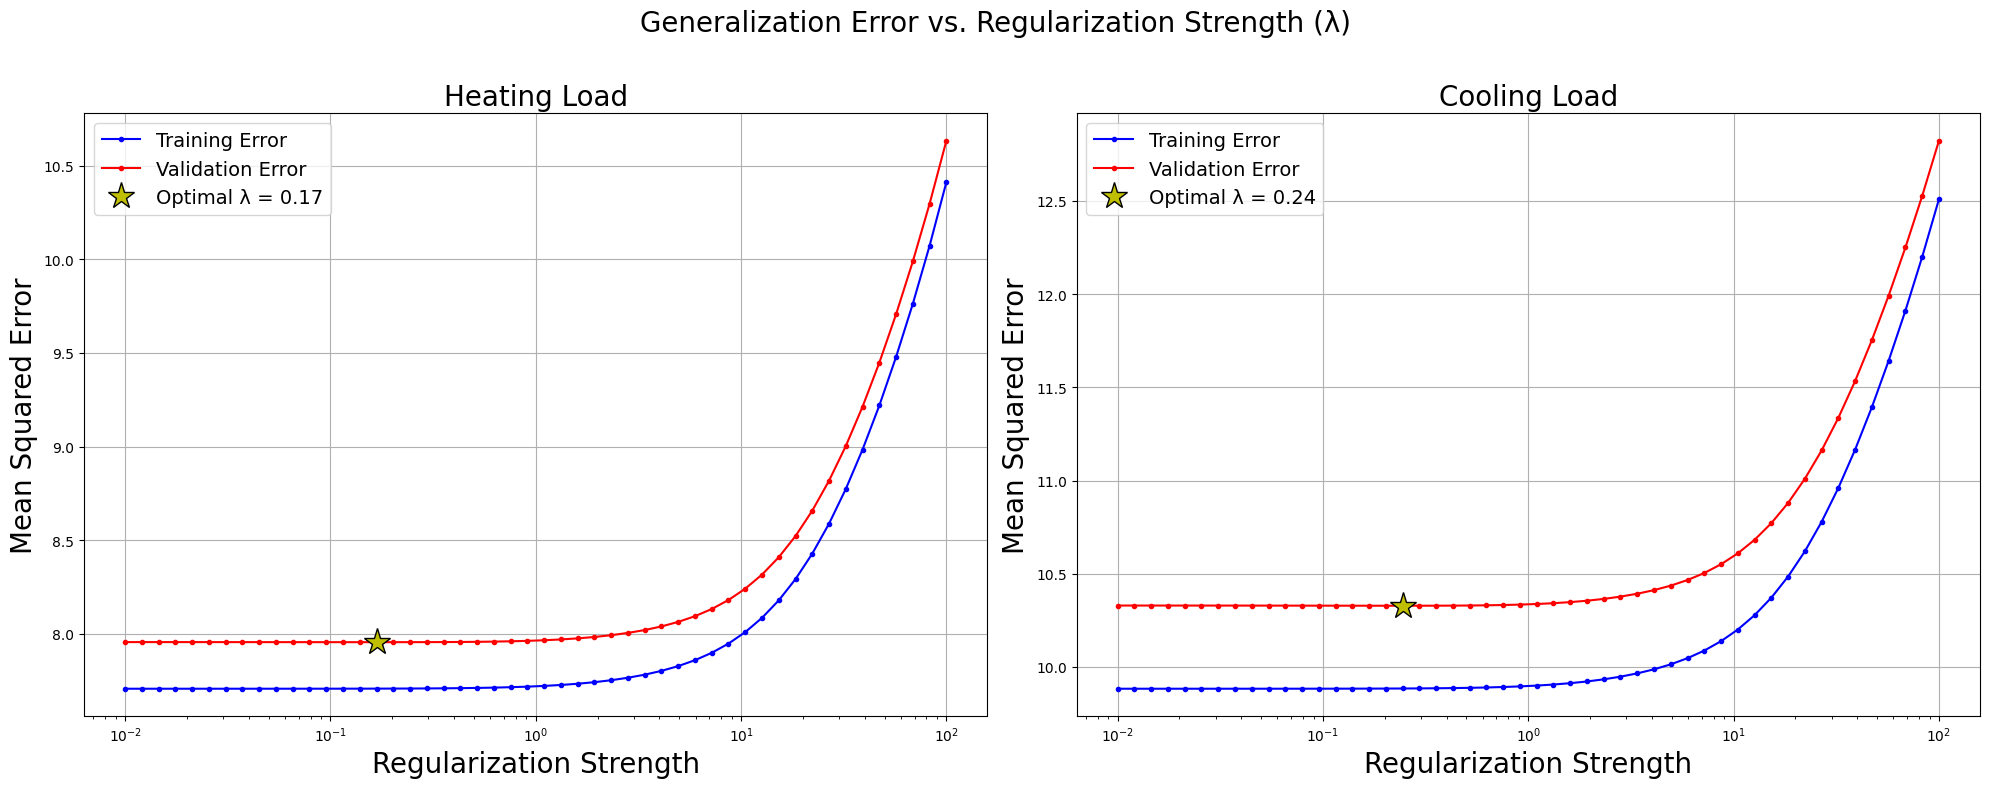

In [4]:
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt

np.random.seed(1234)
lambdas = np.logspace(-2, 2, 50)

numerical_features = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Glazing Area']


def evaluate_regularization(y):
    K = 10
    cv = model_selection.KFold(K, shuffle=True)
    train_errors = np.empty((K, len(lambdas)))
    test_errors = np.empty((K, len(lambdas)))
    for k, (train_index, test_index) in enumerate(cv.split(X)):
        
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            

            mu = np.mean(X_train[numerical_features], axis=0)
            sigma = np.std(X_train[numerical_features], axis=0)


            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()
            

            X_train_scaled[numerical_features] = (X_train[numerical_features] - mu) / sigma
            X_test_scaled[numerical_features] = (X_test[numerical_features] - mu) / sigma

            for lambda_idx, lambda_val in enumerate(lambdas):

                model = Ridge(alpha=lambda_val)
                model.fit(X_train_scaled, y_train)


                train_errors[k, lambda_idx] = np.mean((y_train - model.predict(X_train_scaled))**2)
                test_errors[k, lambda_idx] = np.mean((y_test - model.predict(X_test_scaled))**2)

    return train_errors, test_errors


hl_train_errors, hl_test_errors = evaluate_regularization(y1)
cl_train_errors, cl_test_errors = evaluate_regularization(y2)

avg_hl_train_errors = np.mean(hl_train_errors, axis=0)
avg_hl_test_errors = np.mean(hl_test_errors, axis=0)

avg_cl_train_errors = np.mean(cl_train_errors, axis=0)
avg_cl_test_errors = np.mean(cl_test_errors, axis=0)

optimal_hyperparameter_hl_idx = np.argmin(avg_hl_test_errors)
optimal_hyperparameter_hl = lambdas[optimal_hyperparameter_hl_idx]

optimal_hyperparameter_cl_idx = np.argmin(avg_cl_test_errors)
optimal_hyperparameter_cl = lambdas[optimal_hyperparameter_cl_idx]
min_error_hl = avg_hl_test_errors[optimal_hyperparameter_hl_idx]

min_error_cl = avg_cl_test_errors[optimal_hyperparameter_cl_idx]




fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Generalization Error vs. Regularization Strength (λ)', fontsize=20)


ax1.plot(lambdas, avg_hl_train_errors, 'b.-', label='Training Error')
ax1.plot(lambdas, avg_hl_test_errors, 'r.-', label='Validation Error')
ax1.plot(optimal_hyperparameter_hl, min_error_hl, 'y*', markersize=20, markeredgecolor='k', 
         label=f'Optimal λ = {optimal_hyperparameter_hl:.2f}')
ax1.set_xscale('log')
ax1.set_title('Heating Load', fontsize=20)
ax1.set_xlabel('Regularization Strength', fontsize=20)
ax1.set_ylabel('Mean Squared Error', fontsize=20)
ax1.legend(fontsize=14)
ax1.grid(True)


ax2.plot(lambdas, avg_cl_train_errors, 'b.-', label='Training Error')
ax2.plot(lambdas, avg_cl_test_errors, 'r.-', label='Validation Error')
ax2.plot(optimal_hyperparameter_cl, min_error_cl, 'y*', markersize=20, markeredgecolor='k', 
         label=f'Optimal λ = {optimal_hyperparameter_cl:.2f}')
ax2.set_xscale('log')
ax2.set_title('Cooling Load', fontsize=20)
ax2.set_xlabel('Regularization Strength', fontsize=20)
ax2.set_ylabel('Mean Squared Error', fontsize=20)
ax2.legend(fontsize=14)
ax2.grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



C:\Users\alepe\AppData\Local\Temp\ipykernel_29400\1268805973.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticks(), fontsize=15)
C:\Users\alepe\AppData\Local\Temp\ipykernel_29400\1268805973.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticks(), fontsize=15)


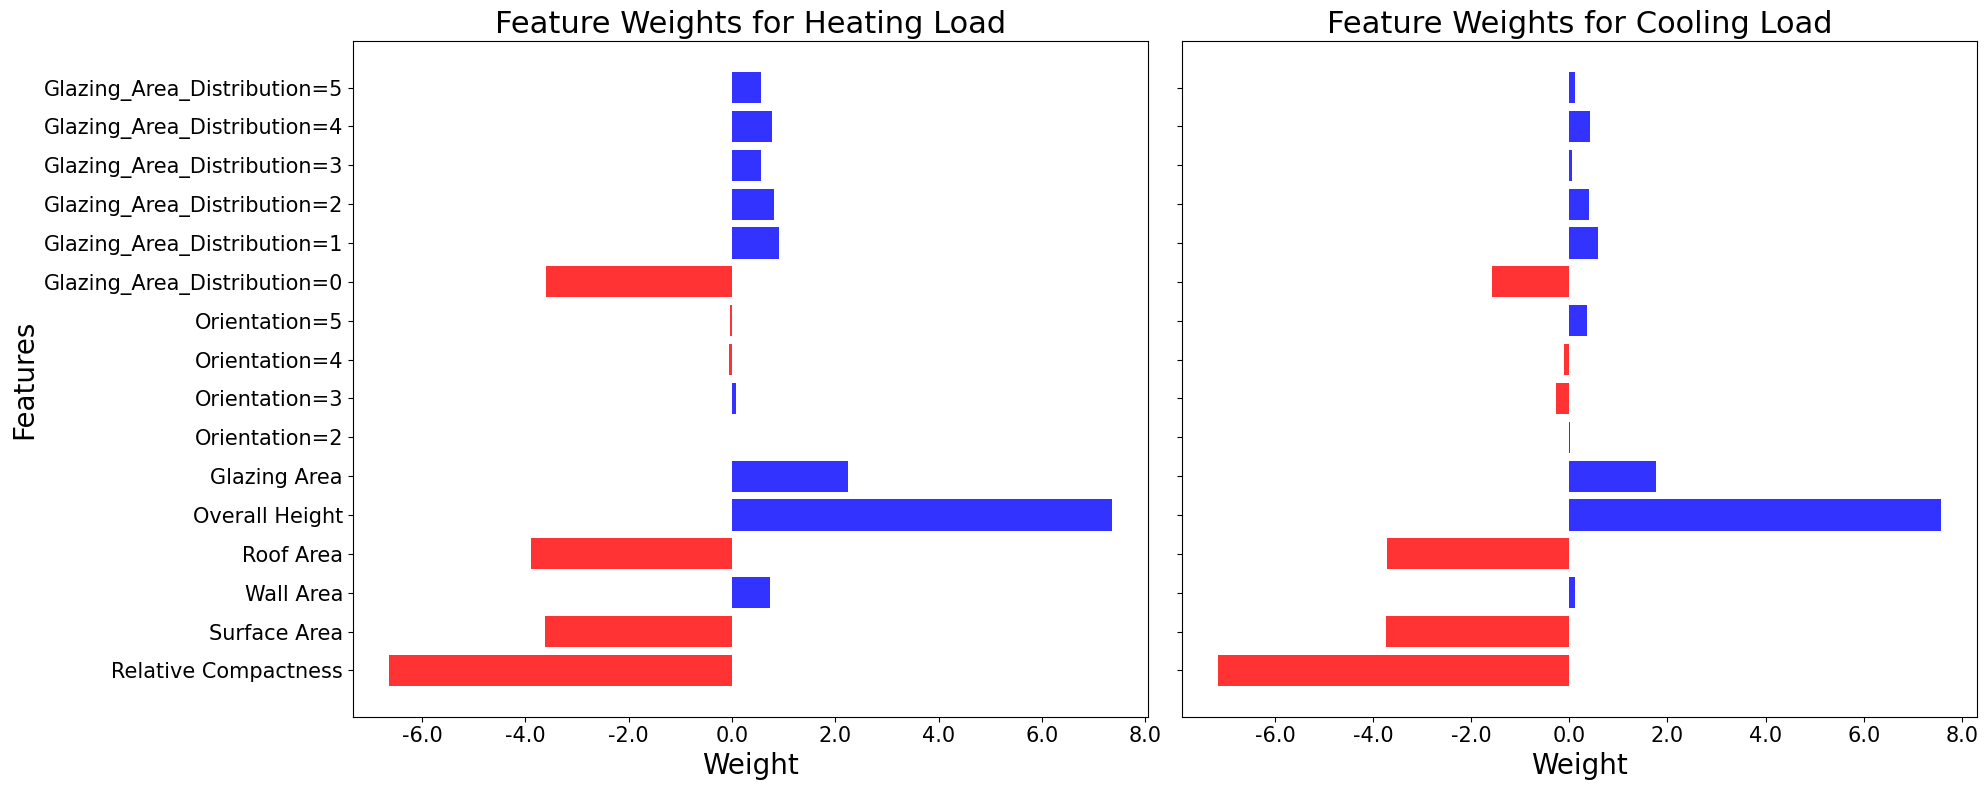

In [27]:
mu = np.mean(X[numerical_features], axis=0)
sigma = np.std(X[numerical_features], axis=0)

X_scaled = X.copy()
X_scaled[numerical_features] = (X[numerical_features] - mu) / sigma
final_model_hl = Ridge(alpha=optimal_hyperparameter_hl)
final_model_hl.fit(X_scaled, y1)
final_model_cl = Ridge(alpha=optimal_hyperparameter_cl)
final_model_cl.fit(X_scaled, y2)
weights_hl = final_model_hl.coef_
weights_cl = final_model_cl.coef_
fig, ax = plt.subplots(1,2,figsize=(20, 8), sharey=True)
y_pos = np.arange(len(X.columns))
ax[0].barh(y_pos, weights_hl, color =['blue' if w>=0 else 'red' for w in weights_hl], alpha=0.8)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(X.columns, fontsize=15)
ax[0].set_title('Feature Weights for Heating Load', fontsize=22)
ax[0].set_xlabel('Weight', fontsize=20)
ax[0].set_xticklabels(ax[0].get_xticks(), fontsize=15)
ax[0].set_ylabel('Features', fontsize=20)
ax[1].barh(y_pos, weights_cl, color =['blue' if w>=0 else 'red' for w in weights_cl], alpha=0.8)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(X.columns, fontsize=15)
ax[1].set_title('Feature Weights for Cooling Load', fontsize=22)
ax[1].set_xlabel('Weight', fontsize=20)
ax[1].set_xticklabels(ax[1].get_xticks(), fontsize=15)
plt.tight_layout()
plt.show()